In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

BATCH_SIZE = 8
IMG_SIZE = (128, 128)
PROJECT_DIR = ".."
DATA_DIR = f"{PROJECT_DIR}/data/processed/PlantVillage"
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 2

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{DATA_DIR}/train",
    labels="inferred",
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/val",
    labels="inferred",
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    labels="inferred",
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 16526 files belonging to 15 classes.


I0000 00:00:1753269056.088591   12814 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1741 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:02:00.0, compute capability: 6.1


Found 6214 files belonging to 15 classes.
Found 4168 files belonging to 15 classes.


In [5]:
class_names = train_ds.class_names

In [6]:
# Debugging: Verify dataset structure and contents
import os

def check_dataset_structure(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {len(files)}")
        print("---")

print("Checking train dataset:")
check_dataset_structure(f"{DATA_DIR}/train")

print("Checking validation dataset:")
check_dataset_structure(f"{DATA_DIR}/val")

print("Checking test dataset:")
check_dataset_structure(f"{DATA_DIR}/test")

Checking train dataset:
Directory: ../data/processed/PlantVillage/train
Subdirectories: ['Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_Leaf_Mold', 'Tomato_Early_blight', 'Potato___Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Pepper__bell___healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato__Target_Spot']
Files: 0
---
Directory: ../data/processed/PlantVillage/train/Potato___Late_blight
Subdirectories: []
Files: 800
---
Directory: ../data/processed/PlantVillage/train/Pepper__bell___Bacterial_spot
Subdirectories: []
Files: 797
---
Directory: ../data/processed/PlantVillage/train/Tomato_healthy
Subdirectories: []
Files: 1272
---
Directory: ../data/processed/PlantVillage/train/Tomato_Spider_mites_Two_spotted_spider_mite
Subdirectories: []
Files: 1340
---
Directory: ../data/processed/PlantVillage/train/Pot

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=BUFFER_SIZE)
val_ds = val_ds.cache().prefetch(buffer_size=BUFFER_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=BUFFER_SIZE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

2025-07-23 11:10:59.207717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-23 11:10:59.276591: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


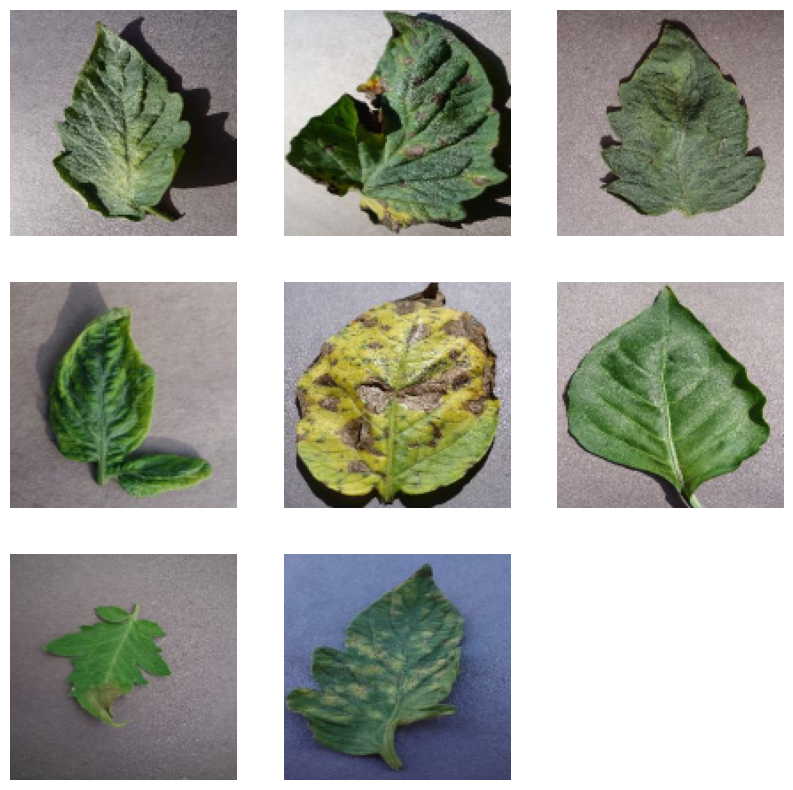

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, images.shape[0])):  # Ensure we don't exceed the batch size
        ax = plt.subplot(3, 3, i + 1)
        img = normalization_layer(images)[i]
        plt.imshow(img.numpy())
        plt.axis("off")
plt.show()


In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze base

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15, activation='softmax')  # adjust this
])


In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


I0000 00:00:1753269065.414482   13421 service.cc:152] XLA service 0x756dc4010770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753269065.414519   13421 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2025-07-23 11:11:05.507326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753269066.136023   13421 cuda_dnn.cc:529] Loaded cuDNN version 90300


  10/2066 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.1610 - loss: 2.7726

I0000 00:00:1753269073.983544   13421 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2066/2066 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.6739 - loss: 1.0325 - val_accuracy: 0.8732 - val_loss: 0.3891
Epoch 2/10
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 65s 31ms/step - accuracy: 0.8510 - loss: 0.4465 - val_accuracy: 0.9115 - val_loss: 0.2700
Epoch 3/10
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 65s 31ms/step - accuracy: 0.8796 - loss: 0.3444 - val_accuracy: 0.9158 - val_loss: 0.2370
Epoch 4/10
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 66s 32ms/step - accuracy: 0.8894 - loss: 0.3082 - val_accuracy: 0.9289 - val_loss: 0.2107
Epoch 5/10
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 65s 31ms/step - accuracy: 0.9116 - loss: 0.2732 - val_accuracy: 0.9322 - val_loss: 0.1966
Epoch 6/10
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 64s 31ms/step - accuracy: 0.9155 - loss: 0.2433 - val_accuracy: 0.9392 - val_loss: 0.1827
Epoch 7/10
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 66s 32ms/step - accuracy: 0.9232 - loss: 0.2183 - val_accuracy: 0.9464 - val_loss: 0.1629
Epoch 8/10
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 66s 32ms/step - accuracy: 0.9337 - loss: 0.19

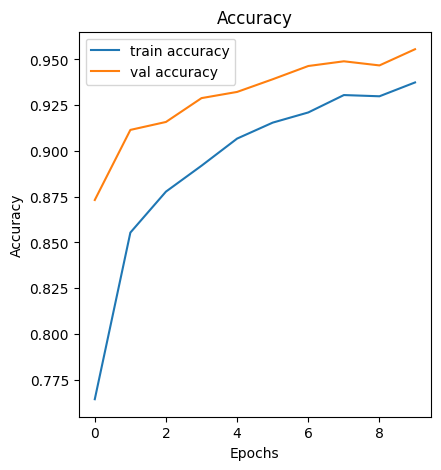

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

521/521 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9295 - loss: 0.2506
Test Loss: 0.294049471616745
Test Accuracy: 0.9124280214309692


In [15]:
# Load and preprocess your custom image
from keras.utils import load_img, img_to_array
import numpy as np

# Path to your custom image
custom_image_path = f"../data/custom/bp_diseased.jpg"  # Replace with your actual image path

# Load the image
image = load_img(custom_image_path, target_size=IMG_SIZE)
image_array = img_to_array(image)  # Convert to numpy array
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
image_array = image_array / 255.0  # Normalize pixel values

# Predict the class
predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=1)

# Map the predicted class index to the class label
print(f"Predicted Class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Tomato_Late_blight


In [16]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(f"{PROJECT_DIR}/models/plant_disease_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite format!")

INFO:tensorflow:Assets written to: /tmp/tmp0pq_pjvw/assets


INFO:tensorflow:Assets written to: /tmp/tmp0pq_pjvw/assets


Saved artifact at '/tmp/tmp0pq_pjvw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  129117594484176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593217424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593217232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117594484368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593217808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593215504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593217616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593215120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593215888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129117593

W0000 00:00:1753269763.564073   12814 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753269763.564093   12814 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-23 11:22:43.564503: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0pq_pjvw
2025-07-23 11:22:43.578205: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-23 11:22:43.578224: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp0pq_pjvw
I0000 00:00:1753269763.693978   12814 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-07-23 11:22:43.715525: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-23 11:22:44.430237: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp0pq_pjvw
2025-07-23 11:22:44.623652: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 